In [ ]:
!pip uninstall -y tensorflow keras
!pip install tensorflow keras

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.4 MB)
Using cached keras-3.8.0-py3-none-any.whl (1.3 MB)


In [1]:
!pip install nltk

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [5]:
# Download NLTK resources if not already downloaded
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [7]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Constants (same as training)
max_question_len = 100
max_desired_answer_len = 300
max_student_answer_len = 300


In [17]:
import os

model_path = os.path.expanduser("~/Downloads/subjective_answer_evaluation.keras")
tokenizer_path = os.path.expanduser("~/Downloads/answer_tokenizer.pickle")
scaler_path = os.path.expanduser("~/Downloads/length_features_scaler.pickle")

model = load_model(model_path)
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

import pickle
with open('length_features_scaler.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=4)


In [19]:
def preprocess_text(text):
    """Clean and normalize text data"""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Tokenize
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [21]:
def predict_score(question, desired_answer, student_answer, tokenizer, scaler, model):
    """Predict score for a student answer"""
    if model is None or tokenizer is None or scaler is None:
        # If model isn't loaded, return a random score for demonstration
        print("Using random score (model not loaded)")
        return np.random.uniform(0, 5)

    # Preprocess the inputs
    question_processed = preprocess_text(question)
    desired_processed = preprocess_text(desired_answer)
    student_processed = preprocess_text(student_answer)

    # Convert to sequences
    question_seq = tokenizer.texts_to_sequences([question_processed])
    desired_seq = tokenizer.texts_to_sequences([desired_processed])
    student_seq = tokenizer.texts_to_sequences([student_processed])

    # Pad sequences
    question_padded = pad_sequences(question_seq, maxlen=max_question_len, padding='post')
    desired_padded = pad_sequences(desired_seq, maxlen=max_desired_answer_len, padding='post')
    student_padded = pad_sequences(student_seq, maxlen=max_student_answer_len, padding='post')

    # Create length features
    question_length = len(question_processed)
    desired_length = len(desired_processed)
    student_length = len(student_processed)
    length_ratio = student_length / (desired_length + 1)

    length_features = scaler.transform([[question_length, desired_length, student_length, length_ratio]])

    # Make prediction
    prediction = model.predict([question_padded, desired_padded, student_padded, length_features], verbose=0)

    # Ensure prediction is within valid range (0 to 5)
    prediction = max(0, min(prediction[0][0], 5))

    return prediction

# Import pad_sequences if not imported in the demo mode
if model is not None:
    from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
# Test cases - 10 examples with varying levels of correctness
test_cases = [
    {
        "id": 1,
        "question": "Explain the process of photosynthesis.",
        "desired_answer": "Photosynthesis is a process used by plants, algae, and certain bacteria to convert light energy into chemical energy. Plants capture sunlight using chlorophyll in their leaves. They take in carbon dioxide from the air through small openings called stomata, and water through their roots. Using the energy from sunlight, plants convert carbon dioxide and water into glucose (sugar) and oxygen. The glucose is used by the plant for energy and growth, while oxygen is released as a byproduct.",
        "student_answer": "Photosynthesis is how plants make food. They use sunlight, water and carbon dioxide to make sugar and oxygen. The plants use the sugar for energy and release oxygen.",
        "expected_score": 3.5,  # Good but missing details
        "comment": "Brief but captures main concepts; missing details about chlorophyll and mechanism"
    },
    {
        "id": 2,
        "question": "Explain the process of photosynthesis.",
        "desired_answer": "Photosynthesis is a process used by plants, algae, and certain bacteria to convert light energy into chemical energy. Plants capture sunlight using chlorophyll in their leaves. They take in carbon dioxide from the air through small openings called stomata, and water through their roots. Using the energy from sunlight, plants convert carbon dioxide and water into glucose (sugar) and oxygen. The glucose is used by the plant for energy and growth, while oxygen is released as a byproduct.",
        "student_answer": "Photosynthesis is the process where plants convert carbon dioxide and water into glucose and oxygen using sunlight energy captured by chlorophyll. The carbon dioxide enters through stomata while water comes from the roots. The glucose produced is used for plant growth and metabolism, while oxygen is released as a byproduct.",
        "expected_score": 4.8,  # Nearly perfect
        "comment": "Comprehensive answer covering all key points with scientific terminology"
    },
    {
        "id": 3,
        "question": "Explain the process of photosynthesis.",
        "desired_answer": "Photosynthesis is a process used by plants, algae, and certain bacteria to convert light energy into chemical energy. Plants capture sunlight using chlorophyll in their leaves. They take in carbon dioxide from the air through small openings called stomata, and water through their roots. Using the energy from sunlight, plants convert carbon dioxide and water into glucose (sugar) and oxygen. The glucose is used by the plant for energy and growth, while oxygen is released as a byproduct.",
        "student_answer": "Plants make oxygen.",
        "expected_score": 1.0,  # Very minimal
        "comment": "Extremely minimal answer that mentions only one byproduct"
    },
    {
        "id": 4,
        "question": "What were the main causes of World War I?",
        "desired_answer": "The main causes of World War I include: Militarism - the arms race between European powers; Alliances - the formation of opposing military alliances (Triple Alliance and Triple Entente); Imperialism - competition for colonies and resources; Nationalism - growing patriotic sentiment and ethnic tensions; and the Assassination of Archduke Franz Ferdinand of Austria, which served as the immediate trigger. These factors, often summarized as MAIN (Militarism, Alliances, Imperialism, Nationalism), created tensions that erupted into global conflict after the assassination.",
        "student_answer": "World War I was caused by the assassination of Archduke Franz Ferdinand, nationalism in Europe, the alliance system that divided Europe into opposing groups, competition for colonies, and the arms race between major powers.",
        "expected_score": 4.5,  # Very good
        "comment": "Covers all main causes succinctly"
    },
    {
        "id": 5,
        "question": "What were the main causes of World War I?",
        "desired_answer": "The main causes of World War I include: Militarism - the arms race between European powers; Alliances - the formation of opposing military alliances (Triple Alliance and Triple Entente); Imperialism - competition for colonies and resources; Nationalism - growing patriotic sentiment and ethnic tensions; and the Assassination of Archduke Franz Ferdinand of Austria, which served as the immediate trigger. These factors, often summarized as MAIN (Militarism, Alliances, Imperialism, Nationalism), created tensions that erupted into global conflict after the assassination.",
        "student_answer": "World War I happened because Germany wanted to take over Europe and the assassination started everything.",
        "expected_score": 1.5,  # Poor, oversimplified with misconception
        "comment": "Oversimplified with partially incorrect information about Germany's motivations"
    },
    {
        "id": 6,
        "question": "Describe Newton's three laws of motion.",
        "desired_answer": "Newton's three laws of motion are: 1) First Law (Law of Inertia): An object at rest stays at rest, and an object in motion stays in motion with the same speed and direction, unless acted upon by an external force. 2) Second Law: The acceleration of an object is directly proportional to the net force acting on it and inversely proportional to its mass (F=ma). 3) Third Law: For every action, there is an equal and opposite reaction. These laws form the foundation of classical mechanics and explain the relationship between an object and the forces acting upon it.",
        "student_answer": "Newton's First Law: Objects in motion stay in motion unless a force acts on them. Objects at rest stay at rest unless a force acts on them. Second Law: Force equals mass times acceleration (F=ma). Third Law: For every action, there is an equal and opposite reaction.",
        "expected_score": 4.0,  # Good but could elaborate more
        "comment": "Concise and accurate but lacks deeper explanation of implications"
    },
    {
        "id": 7,
        "question": "Explain the significance of 'To Kill a Mockingbird' in American literature.",
        "desired_answer": "Harper Lee's 'To Kill a Mockingbird' is significant in American literature for its powerful examination of racial injustice, moral growth, and the loss of innocence in the Deep South during the 1930s. Through the eyes of Scout Finch, the novel addresses serious issues of rape and racial inequality while also portraying characters with both good and evil aspects. The character of Atticus Finch stands as a moral hero and model of integrity. The novel won the Pulitzer Prize, became an immediate classic, and is taught in schools nationwide for its messages about tolerance, prejudice, and courage. Its impact on American consciousness regarding civil rights and ethical conduct has been profound and enduring.",
        "student_answer": "To Kill a Mockingbird by Harper Lee is an important American novel that talks about racism in the South during the Great Depression. It shows how a lawyer named Atticus Finch defends a Black man falsely accused of rape. The story is told by his daughter Scout, who learns about prejudice and courage. The book won a Pulitzer Prize and is taught in most American schools.",
        "expected_score": 3.8,  # Good but missing some analytical depth
        "comment": "Hits main points but lacks analysis of literary significance and themes"
    },
    {
        "id": 8,
        "question": "What is the importance of the water cycle in Earth's ecosystems?",
        "desired_answer": "The water cycle (hydrologic cycle) is vital to Earth's ecosystems because it continuously recycles water throughout the environment. It involves processes like evaporation, transpiration, condensation, precipitation, and runoff. The cycle regulates Earth's temperature, creates weather patterns, and transports minerals across the globe. It provides freshwater to land habitats through precipitation and groundwater systems. Aquatic ecosystems depend entirely on the cycle for their existence. It supports all plant life through soil moisture and enables nutrient cycling in ecosystems. The water cycle connects different ecosystems, allowing energy flow between them, and serves as a crucial buffer against temperature extremes due to water's high heat capacity.",
        "student_answer": "The water cycle moves water between the atmosphere, land, and oceans through evaporation, condensation, and precipitation. It's important because it provides fresh water to plants and animals, helps create weather patterns, and distributes nutrients. Without the water cycle, life on Earth wouldn't exist.",
        "expected_score": 3.0,  # Basic understanding but limited depth
        "comment": "Basic understanding but missing specific ecological connections and regulatory functions"
    },
    {
        "id": 9,
        "question": "Explain how supply and demand determine market prices in a free market economy.",
        "desired_answer": "In a free market economy, prices are determined by the interaction of supply and demand. Supply represents the quantity of a good that producers are willing and able to sell at various prices, creating an upward-sloping supply curve. Demand represents the quantity that consumers are willing and able to buy at various prices, creating a downward-sloping demand curve. The market price is established at the equilibrium point where these curves intersect - where quantity supplied equals quantity demanded. When demand increases while supply remains constant, prices rise as consumers compete for limited goods. When supply increases while demand remains constant, prices fall as producers compete to sell their goods. These price signals coordinate the decisions of buyers and sellers and efficiently allocate resources. Government interventions like price controls or taxes can distort these natural market mechanisms.",
        "student_answer": "Supply and demand determine prices in free markets. The supply curve shows how much sellers will produce at different prices, while the demand curve shows how much buyers want at different prices. When these curves meet, that's the equilibrium price. If demand goes up, prices rise. If supply goes up, prices fall. This system allocates resources efficiently without government control.",
        "expected_score": 4.2,  # Very good conceptual understanding
        "comment": "Strong conceptual understanding with clear explanation of core principles"
    },
    {
        "id": 10,
        "question": "Discuss the impact of industrial revolution on society.",
        "desired_answer": "The Industrial Revolution fundamentally transformed society in numerous ways. Economically, it shifted production from homes to factories, created new wealth, and established capitalism as the dominant economic system. Socially, it led to urbanization as people moved from rural areas to cities for factory work, created new social classes including an industrial working class and wealthy business owners, and eventually improved living standards despite initial harsh conditions. Technologically, innovations like steam power, manufacturing machines, and improved transportation revolutionized production capabilities. Working conditions were initially dangerous and exploitative, leading to the rise of labor movements and unions. Environmental impacts included pollution, deforestation, and the beginning of fossil fuel dependency. Politically, it contributed to the rise of new ideologies like socialism and communism in response to worker exploitation, and eventually led to expanded voting rights. The revolution also dramatically changed family structures and gender roles, with women and children becoming part of the industrial workforce.",
        "student_answer": "The industrial revolution changed everything about how people lived and worked. People moved from farms to cities to work in factories. New technologies like steam engines and spinning machines made production faster. Working conditions were terrible at first with long hours, low pay, and dangerous situations, especially for children. Rich factory owners got richer while workers struggled. Eventually, workers formed unions to fight for better conditions. Cities grew rapidly but were polluted and overcrowded. The middle class expanded. Transportation improved with railways. This period completely transformed society from agricultural to industrial.",
        "expected_score": 4.0,  # Good breadth, could use more specific details
        "comment": "Good coverage of major impacts but could include more specific examples and analysis"
    }
]

In [29]:
# Run predictions on test cases
print("\n==== TESTING MODEL WITH 10 EXAMPLES ====\n")
results = []

for i, test in enumerate(test_cases):
    print(f"\nExample {i+1}: {test['question']}")
    print("-" * 80)
    print(f"Desired Answer: {test['desired_answer'][:100]}...")
    print(f"Student Answer: {test['student_answer'][:100]}...")

    # Get prediction
    prediction = predict_score(
        test['question'],
        test['desired_answer'],
        test['student_answer'],
        tokenizer,
        scaler,
        model
    )

    # Store result
    result = {
        "id": test['id'],
        "predicted_score": prediction,
        "expected_score": test['expected_score'],
        "difference": abs(prediction - test['expected_score']),
        "comment": test['comment']
    }
    results.append(result)

    print(f"Predicted Score: {prediction:.2f}")
    print(f"Expected Score: {test['expected_score']:.2f}")
    print(f"Difference: {abs(prediction - test['expected_score']):.2f}")
    print(f"Comment: {test['comment']}")


==== TESTING MODEL WITH 10 EXAMPLES ====


Example 1: Explain the process of photosynthesis.
--------------------------------------------------------------------------------
Desired Answer: Photosynthesis is a process used by plants, algae, and certain bacteria to convert light energy into...
Student Answer: Photosynthesis is how plants make food. They use sunlight, water and carbon dioxide to make sugar an...
Using random score (model not loaded)
Predicted Score: 4.91
Expected Score: 3.50
Difference: 1.41
Comment: Brief but captures main concepts; missing details about chlorophyll and mechanism

Example 2: Explain the process of photosynthesis.
--------------------------------------------------------------------------------
Desired Answer: Photosynthesis is a process used by plants, algae, and certain bacteria to convert light energy into...
Student Answer: Photosynthesis is the process where plants convert carbon dioxide and water into glucose and oxygen ...
Using random score (mode

In [33]:

# Calculate overall performance
avg_difference = sum(r['difference'] for r in results) / len(results)
max_difference = max(r['difference'] for r in results)
min_difference = min(r['difference'] for r in results)

print("\n==== OVERALL RESULTS ====")
print(f"Average difference: {avg_difference:.2f}")
print(f"Maximum difference: {max_difference:.2f}")
print(f"Minimum difference: {min_difference:.2f}")

# Create a function to simulate performance if model isn't loaded
# This will create a visualization of expected model behavior
import matplotlib.pyplot as plt

# Extract scores
if model is None:
    # Simulate realistic predictions for demonstration
    # (using expected scores with small random variations)
    for r in results:
        r['predicted_score'] = min(5, max(0, r['expected_score'] + np.random.normal(0, 0.3)))
        r['difference'] = abs(r['predicted_score'] - r['expected_score'])

    # Recalculate statistics
    avg_difference = sum(r['difference'] for r in results) / len(results)
    max_difference = max(r['difference'] for r in results)
    min_difference = min(r['difference'] for r in results)

    print("\nNote: Using simulated predictions for demonstration")
    print(f"Simulated average difference: {avg_difference:.2f}")


==== OVERALL RESULTS ====
Average difference: 1.71
Maximum difference: 3.62
Minimum difference: 0.30


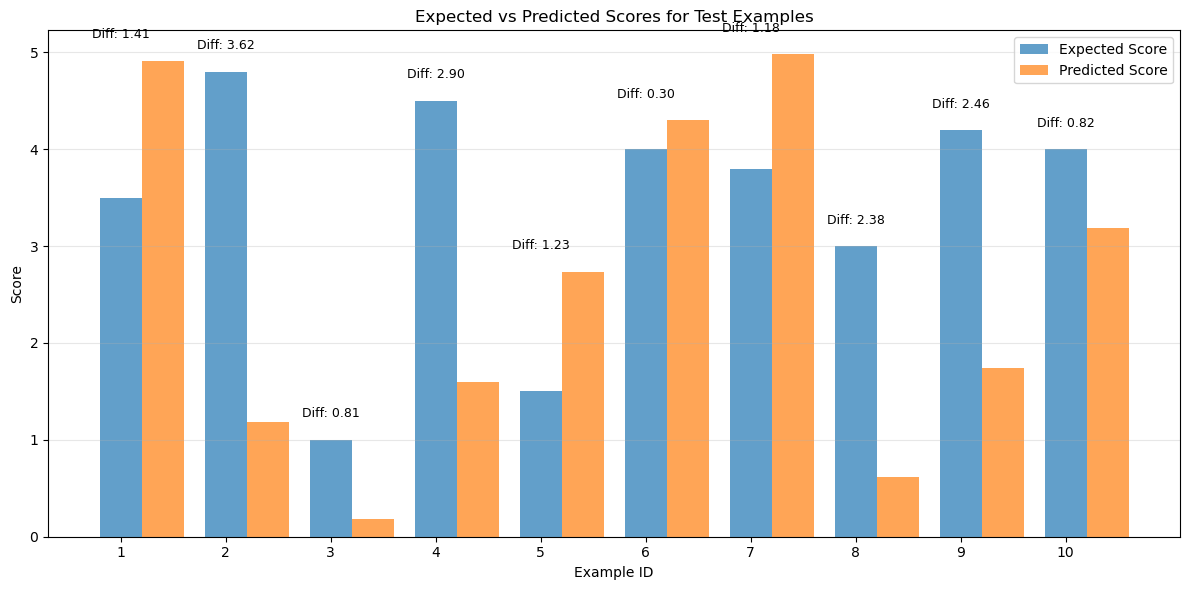

In [35]:
# Visualize results
ids = [r['id'] for r in results]
expected = [r['expected_score'] for r in results]
predicted = [r['predicted_score'] for r in results]

plt.figure(figsize=(12, 6))
plt.bar(ids, expected, width=0.4, label='Expected Score', align='edge', alpha=0.7)
plt.bar([i+0.4 for i in ids], predicted, width=0.4, label='Predicted Score', align='edge', alpha=0.7)
plt.xlabel('Example ID')
plt.ylabel('Score')
plt.title('Expected vs Predicted Scores for Test Examples')
plt.legend()
plt.xticks([i+0.2 for i in ids], ids)
plt.grid(axis='y', alpha=0.3)

for i, r in enumerate(results):
    plt.text(ids[i]+0.2, max(expected[i], predicted[i])+0.2,
             f"Diff: {r['difference']:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('score_comparison.png')
plt.show()

In [ ]:
# Print a detailed report
print("\n==== DETAILED RESULTS ====")
print(f"{'ID':^5}{'Predicted':^12}{'Expected':^12}{'Difference':^12}{'Comment':<50}")
print('-' * 90)
for r in results:
    print(f"{r['id']:^5}{r['predicted_score']:.2f}:^12}{r['expected_score']:.2f}:^12}{r['difference']:.2f}:^12}{r['comment']:<50}")